In [114]:
# ! pip install langgraph elasticsearch openai python-dotenv


In [115]:
# load 
from typing import TypedDict, Literal, List, Dict, Any
from collections import defaultdict

from dotenv import load_dotenv
import os

from elasticsearch import Elasticsearch
from openai import OpenAI

from langgraph.graph import StateGraph, END

# .env 로드
load_dotenv()

# --- OpenAI ---
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY is not set")

client = OpenAI(api_key=OPENAI_API_KEY)

# --- Elasticsearch ---
ES_HOST = os.getenv("ES_HOST", "localhost")
ES_PORT = int(os.getenv("ES_PORT", "9200"))
ES_USER = os.getenv("ES_USER", "elastic")
ES_PASSWORD = os.getenv("ES_PASSWORD", "changeme")
ES_INDEX = os.getenv("ES_INDEX", "papers_index")

es = Elasticsearch(
    hosts=[{"host": ES_HOST, "port": ES_PORT, "scheme": "http"}],
    basic_auth=(ES_USER, ES_PASSWORD),
)

# 필드 이름
TITLE_FIELD = "title"
CONTENT_FIELD = "content"
YEAR_FIELD = "year"
CITATION_FIELD = "citations"
EMBED_FIELD = "embedding"

# 검색 설정
TOP_K_SPARSE = 30
TOP_K_DENSE = 30
TOP_K_FINAL = 10


In [116]:
# 상태 정의 + 공통 llm/임베딩 함수 
# 상태 정의
UtterType = Literal["KEYWORD_TOPIC", "NL_TOPIC", "SPECIFIC_PAPER"]
SearchStrategy = Literal["sparse", "dense", "hybrid"]

class AgentState(TypedDict, total=False):
    query_text: str
    utterance_type: UtterType
    search_strategy: SearchStrategy
    keyword_hits: List[Dict[str, Any]]
    semantic_hits: List[Dict[str, Any]]
    top_papers: List[Dict[str, Any]]
    answer: str
    memory: List[Dict[str, Any]]  # 과거 질의/응답 기록

# LLM / Embedding 헬퍼
def call_llm_json(system_prompt: str, user_prompt: str) -> Dict[str, Any]:
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        response_format={"type": "json_object"},
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
    )
    import json
    return json.loads(resp.choices[0].message.content)

def call_llm_text(system_prompt: str, user_prompt: str) -> str:
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
    )
    return resp.choices[0].message.content

def get_embedding(text: str) -> List[float]:
    emb = client.embeddings.create(
        model="text-embedding-3-large",
        input=text,
    )
    return emb.data[0].embedding

# 메모리 관리를 위해 추가 
def memory_update_agent(state: AgentState) -> AgentState:
    memory = state.get("memory", [])
    query = state.get("query_text", "")
    answer = state.get("answer", "")

    if query and answer:
        memory.append({
            "query": query,
            "answer": answer,
        })
    return {"memory": memory}



In [117]:
# node 1 : classify_utterance 
def classify_utterance_agent(state: AgentState) -> AgentState:
    query = state["query_text"].strip()

    system_prompt = """
너는 논문 검색 에이전트의 인텐트 분류기다.
유저의 질의를 아래 세 유형 중 하나로 분류해라.

- KEYWORD_TOPIC: 키워드 위주의 짧은 검색어
- NL_TOPIC: 자연어 서술형 질문
- SPECIFIC_PAPER: 특정 논문을 가리키는 질문

반드시 JSON으로:
{"utterance_type": "..."}
"""
    user_prompt = f"질문: {query}"
    result = call_llm_json(system_prompt, user_prompt)
    utter: UtterType = result.get("utterance_type", "NL_TOPIC")

    # state["utterance_type"] = utter
    # return state
    return {"utterance_type": utter}


In [118]:
# node2 : strategy_agent
def strategy_agent(state: AgentState) -> AgentState:
    utter = state["utterance_type"]

    if utter == "KEYWORD_TOPIC":
        strategy: SearchStrategy = "sparse"
    elif utter == "SPECIFIC_PAPER":
        strategy = "hybrid"
    else:
        strategy = "hybrid"

    return {"search_strategy": strategy}



In [119]:
# node 3 : keyword_search_agent (BM25)
def keyword_search_agent(state: AgentState) -> AgentState:
    query = state["query_text"]
    strategy = state.get("search_strategy", "hybrid")

    if strategy not in ("sparse", "hybrid"):
        return {"keyword_hits": []}

    body = {
        "size": TOP_K_SPARSE,
        "query": {
            "multi_match": {
                "query": query,
                "fields": [TITLE_FIELD, CONTENT_FIELD],
                "type": "best_fields",
            }
        },
    }
    resp = es.search(index=ES_INDEX, body=body)
    hits = resp["hits"]["hits"]

    results = []
    for h in hits:
        src = h["_source"]
        results.append({
            "id": h["_id"],
            "score": h["_score"],
            "title": src.get(TITLE_FIELD),
            "content": src.get(CONTENT_FIELD),
            "year": src.get(YEAR_FIELD),
            "citations": src.get(CITATION_FIELD, 0),
        })

    return {"keyword_hits": results}


In [120]:
# semantic_search_agent 
def semantic_search_agent(state: AgentState) -> AgentState:
    query = state["query_text"]
    strategy = state.get("search_strategy", "hybrid")

    if strategy not in ("dense", "hybrid"):
        return {"semantic_hits": []}

    q_vec = get_embedding(query)
    body = {
        "size": TOP_K_DENSE,
        "knn": {
            "field": EMBED_FIELD,
            "query_vector": q_vec,
            "k": TOP_K_DENSE,
            "num_candidates": 100,
        },
    }
    resp = es.search(index=ES_INDEX, body=body)
    hits = resp["hits"]["hits"]

    results = []
    for h in hits:
        src = h["_source"]
        results.append({
            "id": h["_id"],
            "score": h["_score"],
            "title": src.get(TITLE_FIELD),
            "content": src.get(CONTENT_FIELD),
            "year": src.get(YEAR_FIELD),
            "citations": src.get(CITATION_FIELD, 0),
        })

    return {"semantic_hits": results}



In [121]:
def rrf_fusion(
    keyword_hits: List[Dict[str, Any]],
    semantic_hits: List[Dict[str, Any]],
    k: int = TOP_K_FINAL,
    k_rrf: int = 60,
) -> List[Dict[str, Any]]:
    scores = defaultdict(float)
    docs: Dict[str, Dict[str, Any]] = {}

    for rank, d in enumerate(keyword_hits):
        doc_id = d["id"]
        scores[doc_id] += 1.0 / (k_rrf + rank + 1)
        docs.setdefault(doc_id, d)

    for rank, d in enumerate(semantic_hits):
        doc_id = d["id"]
        scores[doc_id] += 1.0 / (k_rrf + rank + 1)
        docs.setdefault(doc_id, d)

    fused = sorted(docs.values(), key=lambda d: scores[d["id"]], reverse=True)
    return fused[:k]

In [122]:
def merge_and_select_agent(state: AgentState) -> AgentState:
    keyword_hits = state.get("keyword_hits") or []
    semantic_hits = state.get("semantic_hits") or []

    fused = rrf_fusion(keyword_hits, semantic_hits, k=TOP_K_FINAL)

    query = state.get("query_text", "")

    if not fused:
        return {
            "top_papers": [],
            "answer": "관련 논문을 찾지 못했어. 검색어를 조금 더 구체적으로 바꿔볼래?",
        }

    papers_text = []
    for i, p in enumerate(fused, start=1):
        content = p.get("content") or ""   # ✅ None 방어
        papers_text.append(
            f"{i}. 제목: {p.get('title')}\n"
            f"   연도: {p.get('year')}, 인용수: {p.get('citations')}\n"
            f"   내용: {content[:400]}..."
        )

    papers_block = "\n\n".join(papers_text)

    system_prompt = """
너는 논문 검색 어시스턴트다.
사용자의 질문과 후보 논문 목록을 보고,
- 중요한 3~5편을 골라 제목과 요약을 제시하고
- 왜 관련 있는지 코멘트를 달아라.
- 최신 논문이 있다면 우선 언급해라.

한국어로, 핵심 위주로 설명해라.
"""
    user_prompt = f"질문: {query}\n\n후보 논문 목록:\n{papers_block}"
    answer = call_llm_text(system_prompt, user_prompt)

    return {
        "top_papers": fused,
        "answer": answer,
    }


In [123]:
from init_setting import es, ES_INDEX
print(es.indices.get_mapping(index=ES_INDEX))


{'papers_index': {'mappings': {'properties': {'abstract': {'type': 'text'}, 'citations': {'type': 'integer'}, 'content': {'type': 'text', 'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}, 'embedding': {'type': 'dense_vector', 'dims': 3072, 'index': True, 'similarity': 'cosine', 'index_options': {'type': 'int8_hnsw', 'm': 16, 'ef_construction': 100}}, 'title': {'type': 'text'}, 'url': {'type': 'keyword'}, 'venue': {'type': 'keyword'}, 'year': {'type': 'integer'}}}}}


In [124]:
# def build_graph():
#     workflow = StateGraph(AgentState)

#     workflow.add_node("classify_utterance_agent", classify_utterance_agent)
#     workflow.add_node("strategy_agent", strategy_agent)
#     workflow.add_node("keyword_search_agent", keyword_search_agent)
#     workflow.add_node("semantic_search_agent", semantic_search_agent)
#     workflow.add_node("merge_and_select_agent", merge_and_select_agent)
#     workflow.add_node("memory_update_agent", memory_update_agent) # 메모리 노드 추가 

#     workflow.set_entry_point("classify_utterance_agent")

#     workflow.add_edge("classify_utterance_agent", "strategy_agent")
#     workflow.add_edge("strategy_agent", "keyword_search_agent")
#     workflow.add_edge("strategy_agent", "semantic_search_agent")
#     workflow.add_edge("keyword_search_agent", "merge_and_select_agent")
#     workflow.add_edge("semantic_search_agent", "merge_and_select_agent")

#     workflow.set_finish_point("merge_and_select_agent")

#     return workflow.compile()



from langgraph.graph import StateGraph, END

def build_graph():
    workflow = StateGraph(AgentState)

    # 노드 등록
    workflow.add_node("classify_utterance_agent", classify_utterance_agent)
    workflow.add_node("strategy_agent", strategy_agent)
    workflow.add_node("keyword_search_agent", keyword_search_agent)
    workflow.add_node("semantic_search_agent", semantic_search_agent)
    workflow.add_node("merge_and_select_agent", merge_and_select_agent)
    workflow.add_node("memory_update_agent", memory_update_agent)

    # Entry point 설정
    workflow.set_entry_point("classify_utterance_agent")

    # 기본 흐름
    workflow.add_edge("classify_utterance_agent", "strategy_agent")

    # ✅ Conditional Edge: search_strategy 값에 따라 분기
    workflow.add_conditional_edges(
        "strategy_agent",
        lambda s: s.get("search_strategy", "hybrid"),
        {
            "sparse": "keyword_search_agent",
            "dense": "semantic_search_agent",
            # hybrid은 병렬이 아니라 keyword_search → semantic_search 순차 연결로 처리
            "hybrid": "keyword_search_agent",
        },
    )

    # ✅ hybrid 전략의 두 번째 경로 (keyword 다음 semantic으로 연결)
    workflow.add_conditional_edges(
        "keyword_search_agent",
        lambda s: s.get("search_strategy", "hybrid"),
        {
            "hybrid": "semantic_search_agent",  # hybrid인 경우에만 이어짐
        },
        default="merge_and_select_agent",  # hybrid 외에는 바로 merge로
    )

    # ✅ semantic_search → merge
    workflow.add_edge("semantic_search_agent", "merge_and_select_agent")

    # ✅ merge → memory_update → 종료
    workflow.add_edge("merge_and_select_agent", "memory_update_agent")
    workflow.add_edge("memory_update_agent", END)

    return workflow.compile()
graph = build_graph()


In [125]:
def run_query(q: str):
    state: AgentState = {"query_text": q}
    result = graph.invoke(state)

    print("질문:", q)
    print("\n[질의 유형]:", result.get("utterance_type"))
    print("[검색 전략]:", result.get("search_strategy"))
    print("\n[답변]\n", result.get("answer"))

    print("\n[선택된 논문 리스트]")
    for i, p in enumerate(result.get("top_papers", []), start=1):
        print(f"{i}. {p.get('title')} ({p.get('year')}), citations={p.get('citations')}")




In [126]:
memory_state = []  # 전역 메모리

def run_query(q: str):
    global memory_state

    # 이전 memory_state를 그대로 이어받음
    state: AgentState = {
        "query_text": q,
        "memory": memory_state
    }

    result = graph.invoke(state)

    print("="*80)
    print("질문:", q)
    print("-"*80)
    print("[질의 유형]:", result.get("utterance_type"))
    print("[검색 전략]:", result.get("search_strategy"))
    print("\n[답변]\n", result.get("answer"))

    print("\n[선택된 논문 리스트]")
    for i, p in enumerate(result.get("top_papers", []), start=1):
        print(f"{i}. {p.get('title')} ({p.get('year')}), citations={p.get('citations')}")

    # ✅ memory 업데이트
    memory_state = result.get("memory", memory_state)

    print("\n[누적 메모리 상태]")
    for m in memory_state[-3:]:  # 최근 3개만 보기
        print(f"- {m['query']} → {m['answer'][:50]}...")

    print("="*80)
    return result


테스트

In [127]:
run_query("최근 RAG retriever 설계 관련해서 중요한 논문 몇 개 알려줘")
run_query("그 중 2023년 이후 논문만 다시 정리해줘")
run_query("그 논문들 중 self-consistency 관련 내용은?")


질문: 최근 RAG retriever 설계 관련해서 중요한 논문 몇 개 알려줘
--------------------------------------------------------------------------------
[질의 유형]: NL_TOPIC
[검색 전략]: hybrid

[답변]
 다음은 RAG retriever 설계와 관련하여 중요한 논문들입니다. 

1. **제목: RAG Retriever Optimization for Open-domain QA (2023)**
   - **요약:** 이 논문에서는 RAG 시스템의 검색 컴포넌트를 향상시키기 위한 하이브리드 밀집-희소 접근 방식을 탐구합니다. 이를 통해 개방형 질문 응답(OAQ) 시스템의 성능 최적화를 목표로 하였습니다.
   - **관련성:** 최신 연구로서 RAG retriever의 최적화 방법에 대한 심층적인 논의를 포함하고 있어, RAG 설계 및 성능 향상에 직접적인 기여를 합니다. 

2. **제목: Agentic RAG for Scientific Paper Search (2024)**
   - **요약:** 이 논문은 과학 논문 검색을 위한 RAG 구조를 제안합니다. 효율적인 정보 검색 및 삽입을 통해 과학 연구에 특화된 정보 접근 방식을 연구합니다.
   - **관련성:** 가장 최신의 연구로, RAG을 활용한 특정 도메인(과학 논문 검색)의 적용 사례를 다루고 있어, RAG retriever의 발전 방향과 실제 활용 가능성을 제시합니다.

3. **제목: Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks (2020)**
   - **요약:** RAG 모델에 대해 설명하며, 사전 훈련된 매개변수 및 비매개변수 메모리를 결합하여 개방형 질문 응답과 지식 집약적 작업을 수행하는 방안을 제시합니다.
   - **관련성:** RAG의 기본적인 원리를 세운 논문으로, 현재 RAG 시스템의 구조를 정의하고 있는 중요한 자료입니

{'query_text': '그 논문들 중 self-consistency 관련 내용은?',
 'utterance_type': 'NL_TOPIC',
 'search_strategy': 'hybrid',
 'keyword_hits': [{'id': 'p3',
   'score': 1.9277277,
   'title': 'Self-Attention is All You Need',
   'content': None,
   'year': 2017,
   'citations': 10000},
  {'id': 'paper_1',
   'score': 1.4625918,
   'title': 'Attention Is All You Need',
   'content': 'Attention Is All You Need\n\nWe propose the Transformer, a novel neural network architecture based entirely on self-attention mechanisms, dispensing with recurrence and convolutions entirely.',
   'year': 2017,
   'citations': 45000}],
 'semantic_hits': [{'id': 'paper_1',
   'score': 0.5878148,
   'title': 'Attention Is All You Need',
   'content': 'Attention Is All You Need\n\nWe propose the Transformer, a novel neural network architecture based entirely on self-attention mechanisms, dispensing with recurrence and convolutions entirely.',
   'year': 2017,
   'citations': 45000},
  {'id': 'paper_2',
   'score': 0.5671115

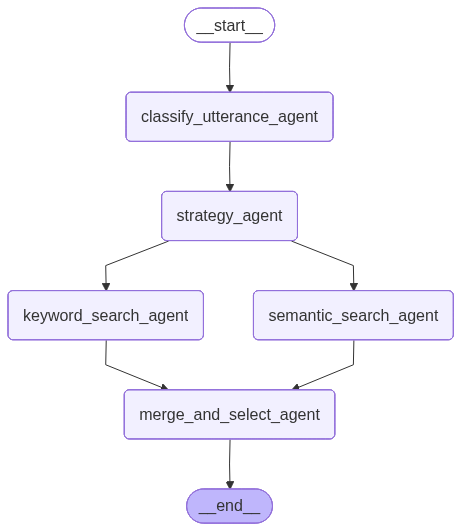

In [129]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [131]:
# import gradio as gr

# # 전역 메모리 (세션 단위로 쓰고 싶으면 gr.State를 같이 쓰면 됨)
# def agent_search(query: str, memory: list | None):
#     """
#     Gradio에서 호출할 함수.
#     - query: 사용자가 입력한 질문
#     - memory: 이전 질의/응답 리스트 (없으면 [])
#     """
#     if memory is None:
#         memory = []

#     state: AgentState = {
#         "query_text": query,
#         "memory": memory,
#     }

#     result = graph.invoke(state)

#     # LLM 답변
#     answer = result.get("answer", "")

#     # 논문 리스트 텍스트로 정리
#     papers = result.get("top_papers", []) or []
#     paper_lines = []
#     for i, p in enumerate(papers, start=1):
#         paper_lines.append(
#             f"{i}. {p.get('title')} "
#             f"({p.get('year')}, 인용수: {p.get('citations')})"
#         )
#     papers_text = "\n".join(paper_lines) if paper_lines else "선택된 논문이 없습니다."

#     # 질의 유형 / 전략
#     utter = result.get("utterance_type")
#     strategy = result.get("search_strategy")

#     diag_lines = [
#         f"- 질의 유형: {utter}",
#         f"- 검색 전략: {strategy}",
#         f"- 키워드 결과 개수: {len(result.get('keyword_hits') or [])}",
#         f"- 의미 검색 결과 개수: {len(result.get('semantic_hits') or [])}",
#     ]
#     diag_text = "\n".join(diag_lines)

#     # 메모리 업데이트
#     new_memory = result.get("memory", memory)

#     # Gradio 출력은 (요약답변, 논문리스트, 진단정보, 메모리)
#     return answer, papers_text, diag_text, new_memory


# with gr.Blocks() as demo:
#     gr.Markdown("## 🧠 Dr.Paper – 논문 검색 & 추천 에이전트")
#     gr.Markdown("질문의 의도를 분석해서 최적 검색 전략(키워드 ↔ 의미 ↔ 하이브리드)을 선택하고, 논문 검색 및 요약을 제공합니다.")

#     memory_state = gr.State([])  # 메모리 상태

#     with gr.Row():
#         with gr.Column(scale=2):
#             search_mode = gr.Radio(
#                 ["자동 판단", "키워드 검색", "자연어 검색", "특정 논문"],
#                 value="자동 판단",
#                 label="검색 모드 (표시용, 실제 전략은 에이전트가 결정)",
#             )
#             query_box = gr.Textbox(
#                 label="질문",
#                 placeholder="예: agentic RAG 관련 최신 논문 추천해줘",
#             )
#             run_btn = gr.Button("🔍 진단하기")

#             diag_box = gr.Textbox(
#                 label="AI 진단 (질의 유형 / 검색 전략 / 결과 개수)",
#                 lines=5,
#                 interactive=False,
#             )

#         with gr.Column(scale=3):
#             answer_box = gr.Markdown(label="AI 요약 답변")
#             papers_box = gr.Textbox(
#                 label="채택된 논문 목록",
#                 lines=10,
#                 interactive=False,
#             )

#     # 버튼 클릭 시 호출되는 이벤트
#     def on_click(query, mem, _mode):
#         # mode(라디오)는 지금은 UI 표시용, 나중에 state에 넣고 활용 가능
#         return agent_search(query, mem)

#     run_btn.click(
#         fn=on_click,
#         inputs=[query_box, memory_state, search_mode],
#         outputs=[answer_box, papers_box, diag_box, memory_state],
#     )

# demo.launch()


/Users/simsewon/AI프로그래밍/paper_search_agent_project/venv_paper_agent/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
